In [89]:
import maxvolpy.maxvol as mv
import numpy as np
import pandas as pd

from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix

from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

In [109]:
train = np.loadtxt('arcene/arcene_train.data')
train_labels = np.loadtxt('arcene/arcene_train.labels')
valid = np.loadtxt('arcene/arcene_valid.data')
valid_labels = np.loadtxt('arcene/arcene_valid.labels')


In [112]:
np.linalg.matrix_rank(train)

100

In [110]:
scaler = MinMaxScaler() 
train = scaler.fit_transform(train)
valid = scaler.transform(valid)

In [113]:
np.linalg.matrix_rank(train)

100

In [22]:
%%time
k = 500
inds, C = mv.rect_maxvol(train.T, maxK=k, minK=k)

non_inds = [i for i in range(train.shape[1]) if i not in inds]
train_maxvol = train[:, inds]
valid_maxvol = valid[:, inds]

CPU times: user 8.22 s, sys: 899 ms, total: 9.12 s
Wall time: 2.5 s


In [23]:
model = LinearRegression()

# fit on all features
model_full = model.fit(train, train_labels)
full_acc = model_full.score(valid, valid_labels) 
print(f'Full model accuracy: {full_acc:.2f}')

# fit on maxvol features
model_maxvol = model.fit(train_maxvol, train_labels)
print(f'Maxvol model accuracy: {model_maxvol.score(valid_maxvol, valid_labels):.2f}')

# fit on non-maxvol features
model_maxvol = model.fit(train[:, non_inds], train_labels)
print(f'Non-maxvol model accuracy: {model_maxvol.score(valid[:, non_inds], valid_labels):.2f}')

# fit on random features
rand_accuracies = []
for i in range(100):
    rand_indices = np.random.choice(train.shape[1], k, replace=False)
    train_rand = train[:, rand_indices]
    valid_rand = valid[:, rand_indices]
    
    model_rand = model.fit(train_rand, train_labels)
    rand_accuracies.append(model_rand.score(valid_rand, valid_labels))
    
print(f'Mean random feature choice accuracy: {np.array(rand_accuracies).mean():.2f}')

Full model accuracy: 0.73
Maxvol model accuracy: 0.51
Non-maxvol model accuracy: 0.69
Mean random feature choice accuracy: 0.68


In [73]:
maxvol_indices = {}
with open('maxvol_arcene_indices.txt', 'r') as f:
    for line in f:
        inds = np.array(list(map(int, line.split())))
        maxvol_indices[len(inds)] = inds

In [91]:
maxvol_indices = {}

In [106]:
%%time

mv_accs = []
non_mv_accs = []
mean_rand_accs = []

k_range = [150, 500, 1000, 3000, 5000, 7000, 9000]
for k in k_range:
    print(f'Processing k = {k}')
    if k in maxvol_indices:
        inds = maxvol_indices[k]
    else:
        inds, C = mv.rect_maxvol(train.T, maxK=k, minK=k)
        maxvol_indices[k] = inds
        
    non_inds = [i for i in range(train.shape[1]) if i not in inds]
    train_maxvol = train[:, inds]
    valid_maxvol = valid[:, inds]
    
    # fit on maxvol features
    model_maxvol = model.fit(train_maxvol, train_labels)
    mv_accs.append(model_maxvol.score(valid_maxvol, valid_labels))

    # fit on non-maxvol features
    model_nonmaxvol = model.fit(train[:, non_inds], train_labels)
    non_mv_accs.append(model_nonmaxvol.score(valid[:, non_inds], valid_labels))

    # fit on random features
    rand_accuracies = []
    for i in range(100):
        rand_indices = np.random.choice(train.shape[1], k, replace=False)
        train_rand = train[:, rand_indices]
        valid_rand = valid[:, rand_indices]

        model_rand = model.fit(train_rand, train_labels)
        rand_accuracies.append(model_rand.score(valid_rand, valid_labels))

    mean_rand_accs.append(np.array(rand_accuracies).mean())

Processing k = 150
Processing k = 500
Processing k = 1000
Processing k = 3000
Processing k = 5000
Processing k = 7000
Processing k = 9000
CPU times: user 26.7 s, sys: 27.8 s, total: 54.4 s
Wall time: 14 s


In [103]:
'''
with open('maxvol_arcene_indices_minmax.txt', 'w') as f:
    for k in maxvol_indices:
        f.write(' '.join(map(str, maxvol_indices[k])) + '\n')
'''

In [115]:
# fit on non-maxvol features
pca = PCA().fit(train)
model_pca = model.fit(pca.transform(train), train_labels)
pca_acc = model_pca.score(pca.transform(valid), valid_labels)

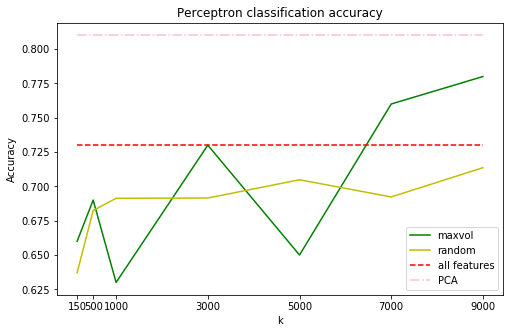

In [116]:
plt.figure(figsize=(8, 5))

plt.plot(k_range, mv_accs, c='g', label='maxvol')
#plt.plot(k_range, non_mv_accs, c='b', label='non-maxvol')
plt.plot(k_range, mean_rand_accs, c='y', label='random')
plt.plot(k_range, [full_acc] * len(k_range), c='r', linestyle='--', label='all features')
plt.plot(k_range, [pca_acc] * len(k_range), c='pink', linestyle='-.', label='PCA')

plt.title('Perceptron classification accuracy')
plt.legend()
plt.xticks(k_range)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()